# Plate 8
## Preprocessing

In [4]:
import pandas as pd
import numpy as np

def convert_time(time):
    # return time in hours and correct for day overflow (datetime object has attribute year only if it is more than 24h after start)
    '''Converts the data format into seconds'''
    h,m,s = (time.hour,time.minute,time.second)
    return (int(h) * 3600 + int(m) * 60 + int(s))/3600 + (24 if hasattr(time,"year") else 0)


def get_dataframe_from_xlsx(path):
    df = pd.read_excel(path,header=None)

    df_list = np.split(df, df[df.isnull().all(1)].index)
    df_list_new = []
    for i in range(len(df_list)):
        df = df_list[i]
        df.columns = df.iloc[0 if i == 0 else 1] #set header
        df = df.iloc[1 if i == 0 else 2:] #delete first row (header)
        df = df.set_index('Kinetic read') #set index
        df.index = df.index.map(convert_time) #convert datetime.time into seconds
        df = df[df.columns.dropna()] #remove empty columns
        df = df.dropna() #remove all empty lines
        df_list_new.append(df)
    return pd.concat(df_list_new,axis=1)

df = get_dataframe_from_xlsx('../data/202000815_iGEM2020-KO-Fitness-plate8.xlsx')
df.head()

,A1,B1,C1,D1,E1,F1,G1,H1,A2,B2,...,G11,H11,A12,B12,C12,D12,E12,F12,G12,H12
Kinetic read,,,,,,,,,,,,,,,,,,,,,
0.072778,0.12,0.116,0.115,0.118,0.121,0.123,0.114,0.115,0.115,0.118,...,0.116,0.113,0.119,0.119,0.115,0.117,0.093,0.092,0.11,0.109
0.156111,0.119,0.116,0.114,0.117,0.118,0.122,0.113,0.114,0.115,0.118,...,0.116,0.113,0.118,0.119,0.115,0.117,0.093,0.092,0.11,0.109
0.239444,0.122,0.115,0.113,0.117,0.124,0.121,0.113,0.114,0.114,0.117,...,0.115,0.113,0.117,0.118,0.114,0.116,0.093,0.091,0.109,0.109
0.322778,0.118,0.115,0.113,0.117,0.117,0.121,0.113,0.114,0.114,0.117,...,0.115,0.113,0.117,0.118,0.114,0.116,0.093,0.091,0.11,0.108
0.406111,0.118,0.115,0.113,0.116,0.118,0.121,0.112,0.114,0.114,0.116,...,0.115,0.113,0.117,0.118,0.114,0.116,0.093,0.091,0.109,0.109


## Boxplot

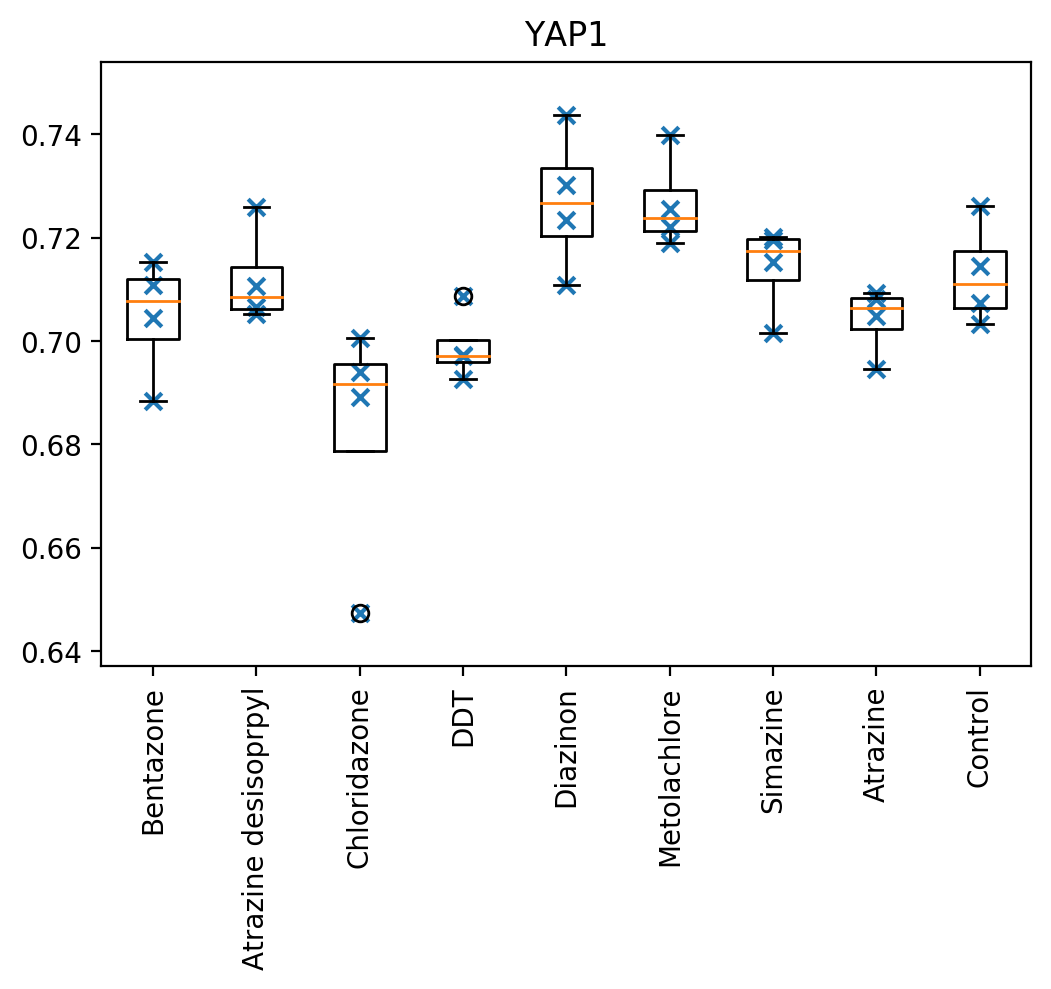

In [12]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200
import sys
from scipy.optimize import curve_fit
import string
import matplotlib.pyplot as plt

try: df
except: sys.exit('Data not loaded!')
pesticides = ['Bentazone','Atrazine desisoprpyl','Chloridazone','DDT','Diazinon','Metolachlore','Simazine','Atrazine','Control']
alph = string.ascii_uppercase

def logistic(x,x0,y0,k,L):
    '''Logistic function'''
    return L/(1+np.exp(-k*(x-x0))) + y0

def get_fit(df,col,init_vals):
    '''Fit the logistic model and get the best parameters'''
    t = np.array(df.index)
    od = np.array(df[col],dtype=float)
    try:
        best_vals, covar = curve_fit(logistic, t, od, p0=init_vals)
        return best_vals
    except RuntimeError:
        return [0,0,0,0]

def getK(i,l):
    k = []
    for j in range(4):
        col = str(i+1)
        row = alph[l+j]
        fit = get_fit(df,(row+col),[13,0.3,0.7,0.8])
        k.append(fit[2])
    return k

K = [getK(i,4) for i in range(len(pesticides))]
x = [i//4+1 for i in range(len(pesticides)*4)]
fig, ax = plt.subplots()
plt.scatter(x,K,marker='x')
plt.boxplot(K)
ax.set_xticklabels(pesticides)
plt.xticks(rotation=90)
plt.title('YAP1')
plt.show()

In [10]:
import string
from scipy.stats import ttest_ind

alph = string.ascii_uppercase
#estimating k for wildtype
k_control = []
for i in range(4):
    col = str(9)
    row = alph[i+4]
    fit = get_fit(df,(row+col),[12.5,0.3,1,0.8])
    k_control.append(fit[2])

print('t-test (alpha=0.05) for the growth rate k at 100ug/l compared to methanol control (+ = significant difference in mean(k))')
pesticides = ['Bentazone','Atrazine desisoprpyl','Chloridazone','DDT','Diazinone','Metolachlore','Simazine','Atrazine']
for i in range(len(pesticides)):
    k = []
    for j in range(4):
        col = str(i+1)
        row = alph[j+4]
        fit = get_fit(df,(row+col),[12.5,0.3,1,0.8])
        k.append(fit[2])
    print(pesticides[i], '+' if ttest_ind(k_control,k).pvalue < 0.05 else '-',ttest_ind(k_control,k).pvalue)

t-test (alpha=0.05) for the growth rate k at 100ug/l compared to methanol control (+ = significant difference in mean(k))
Bentazone - 0.3350427788825096
Atrazine desisoprpyl - 0.9146812747169002
Chloridazone - 0.060582240752456516
DDT - 0.062255388360825635
Diazinone - 0.14481108574340112
Metolachlore - 0.08936303995227336
Simazine - 0.8504021312182453
Atrazine - 0.2015211120613626
